In [29]:
%pip install --quiet tensorflow pandas scikit-learn matplotlib  tensorflow-datasets

import tensorflow as tf
from tensorflow.keras import layers,Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from collections import Counter
import seaborn as sns
import pandas as pd


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'horses_or_humans',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True
)

# Data augmentation
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Apply preprocessing and batching
BATCH_SIZE = 32
ds_train = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [15]:
ds_info
# get dataset info

tfds.core.DatasetInfo(
    name='horses_or_humans',
    full_name='horses_or_humans/3.0.0',
    description="""
    A large set of images of horses and humans.
    """,
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    data_dir='C:\\Users\\kulas\\tensorflow_datasets\\horses_or_humans\\3.0.0',
    file_format=tfrecord,
    download_size=153.59 MiB,
    dataset_size=153.53 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <SplitInfo num_examples=256, num_shards=1>,
        'train': <SplitInfo num_examples=1027, num_shards=2>,
    },
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/h

In [16]:

ds_info.features['label'].names
#check the labels

['horses', 'humans']

<Axes: xlabel='Category', ylabel='Count'>

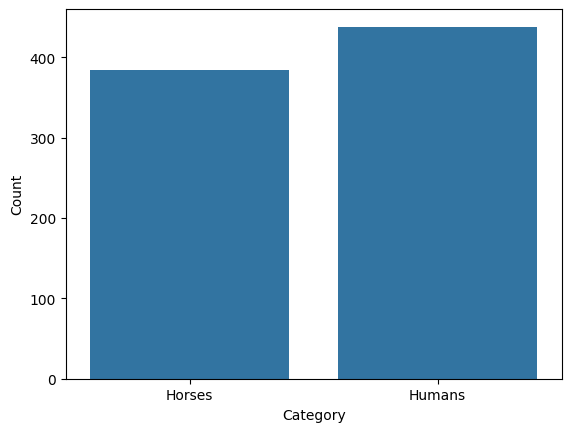

In [32]:
# Function to count occurrences of each class
def count_classes(dataset):
    horse_count = 0
    human_count = 0
    
    for image, label in dataset:
        horse_count += tf.reduce_sum(tf.cast(label == 0, tf.int32)).numpy()
        human_count += tf.reduce_sum(tf.cast(label == 1, tf.int32)).numpy()
        
    return horse_count, human_count

train_horses, train_humans = count_classes(ds_train)

data = {
    'Category': ['Horses', 'Humans'],
    'Count': [train_horses, train_humans],
}

df = pd.DataFrame(data)
sns.barplot(x='Category', y='Count', data=df)

In [ ]:
model = Sequential([
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10


c:\Users\kulas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.5690 - loss: 0.7549 - val_accuracy: 0.7854 - val_loss: 0.4320
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - accuracy: 0.8462 - loss: 0.3863 - val_accuracy: 0.9317 - val_loss: 0.1359
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - accuracy: 0.9147 - loss: 0.2437 - val_accuracy: 0.9561 - val_loss: 0.1299
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 246ms/step - accuracy: 0.9039 - loss: 0.2293 - val_accuracy: 0.9415 - val_loss: 0.1270
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 314ms/step - accuracy: 0.9342 - loss: 0.1698 - val_accuracy: 0.9073 - val_loss: 0.2255
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 293ms/step - accuracy: 0.9404 - loss: 0.1696 - val_accuracy: 0.9610 - val_loss: 0.1099
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 281ms/step - accuracy: 0.9276 - loss: 0.1707 - val_accuracy: 0.9463 - val_loss: 0.1269
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.9622 - loss: 0.1075 - val_accuracy: 0.9659 - val_

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


<Figure size 800x600 with 0 Axes>

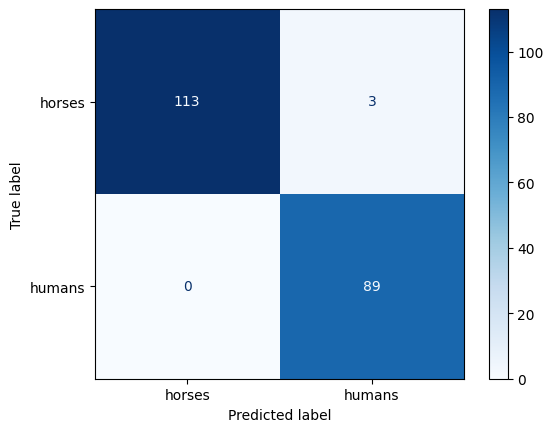

In [ ]:
# Predict on test set
predictions = model.predict(ds_test)
predicted_classes = (predictions > 0.5).astype("int32").flatten()

true_labels = []
for _, labels in ds_test:
    true_labels.extend(labels.numpy())

cm = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['horses', 'humans'])
disp.plot(cmap=plt.cm.Blues)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


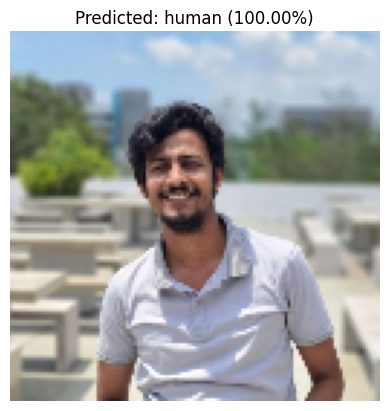

In [36]:
import requests
from PIL import Image
import numpy as np
from io import BytesIO

url = "https://avatars.githubusercontent.com/u/154827022?v=4"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")
img,_ = preprocess(img, None) 
img_array = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict with your model
prediction = model.predict(img_array)

# If binary classification (e.g., horses vs humans)
confidence = prediction[0][0] * 100
predicted_class = 'human' if prediction[0][0] > 0.5 else 'horse'
plt.imshow(img)
plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
plt.axis('off')
plt.show()


In [37]:
#save model to disk
model.save('horse_or_human_model.h5')
